In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import os
import sys
main_dir = 'C:/Users/nourisa/Downloads/testProjs/geneRNI/'

In [93]:
# param tuning
from geneRNI import tools
from geneRNI import geneRNI
from geneRNI import search_param
import importlib
importlib.reload(search_param)
TS_data, time_points, SS_data, gene_names = tools.Benchmark.f_data_dream4(10,1)
Xs, ys = tools.Data.process(TS_data = TS_data, SS_data = SS_data, time_points = time_points, gene_names=gene_names, regulators = 'all', KO = None, verbose=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(Xs, ys, test_size=.2)
distributions = dict(alpha=np.arange(0,1,.1))
best_scores, best_params, best_ests, sampled_permts_sorted = search_param.rand_search(X_train, y_train, param = {'estimator_t':'RF'}, param_grid=distributions, n_jobs = 10)
print(np.mean(best_scores))

dynamic data: ngenes: 10, nsamples: 90, n regulators: 10
static data: ngenes: 10, nsamples: 31, n regulators: 10
stats: 10 genes 10 permts 10 threads
Running 10 samples randomly
Permutation-based multi threading
Param search is completed in 2.095 seconds
0.9529307972151142


In [34]:
# run network inference
from geneRNI import tools
from geneRNI import geneRNI
import importlib
importlib.reload(tools)
TS_data, time_points, SS_data, gene_names = tools.Benchmark.f_data_dream4(10,1)
Xs, ys = tools.Data.process(TS_data = TS_data, SS_data = SS_data, time_points = time_points, gene_names=gene_names, regulators = 'all', KO = None, verbose=True)
param = {
    'estimator_t' : 'RF' 
}
ests, train_scores, links_df, oob_scores, test_scores = geneRNI.network_inference(Xs, ys, gene_names, param, param_unique = None, Xs_test=None, ys_test=None, verbose=True)

dynamic data: ngenes: 100, nsamples: 180, n regulators: 100
static data: ngenes: 100, nsamples: 201, n regulators: 100

network inference: train score, mean: 0.9488575283255746 std: 0.013888741079021358
network inference: oob score (only RF), mean: 0.6272023789859613 std: 0.10276673716260273


In [41]:
# calculate PR and the area under PR
golden_links = tools.Benchmark.f_golden_dream4(100,1)
precision, recall, average_precision, average_precision['micro']  = tools.GOF.calculate_PR(gene_names, links=links_df, golden_links=golden_links, details = True, regulator_tag='Regulator', target_tag='Target', weight_tag='Weight')

In [40]:
average_precision['micro']

0.013498836484200184

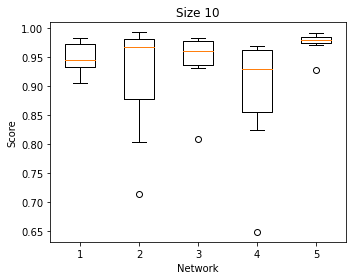

In [43]:
# plot score results
from geneRNI import tools
import ast
# importlib.reload(tools)
# plot scores for individual network
estimator_t = 'RF'
dir_results = os.path.join(main_dir, f'results/dream4/{estimator_t}_best_scores.txt')
with open(dir_results) as f:
    scores_stack = ast.literal_eval(f.read())['best_scores']
tools.GOF.boxplot_scores_groupOfgroup([list(item.values()) for item in scores_stack.values()] ,
                                      tags = [str(i) for i in range(1,6)], titles=['Size 10', 'Size 100'])


In [59]:
# post processing: calculate links, golden precision scores
import os
import ast
import importlib
import pandas as pd
import numpy as np
from geneRNI import search_param
from geneRNI import tools
from geneRNI import geneRNI as ni
import itertools
import random
importlib.reload(search_param)
importlib.reload(ni)
importlib.reload(tools)

dir_main = 'C:/Users/nourisa/Downloads/testProjs/geneRNI'
output_dir=os.path.join(dir_main,'results')
# choose the study 
size, network, study= 100, 1, 'dreams'
# method, noise_level, network, study= 'GeneNetWeaver', 'LowNoise', 'Network1', 'GRNbenchmark'

# recreate the experiment
estimator_t = 'RF' #'HGB'
study = 'dreams' #'GRNbenchmark'

if study == 'dreams': # dream as target study
    out_data = tools.Benchmark.process_data_dream4(size=size, network=network, estimator_t=estimator_t)
    results_dir = f'results/dream4/{estimator_t}/param_search_dream_{size}_{network}.txt'
elif study == 'GRNbenchmark':
    method, noise_level, network = 'GeneNetWeaver', 'LowNoise', 'Network1'
    out_data = tools.Benchmark.process_data_GRNbenchmark(method, noise_level, network, estimator_t=estimator_t)
    results_dir = f'results/param_search_GRNbenchmark_{method}_{noise_level}_{network}.txt'
else:
    raise ValueError('Define')
out_defaults = tools.Settings.default(estimator_t=estimator_t)

# retreieve param search results
with open(results_dir,'r') as f:
    out = ast.literal_eval(f.read())
best_scores, best_params = out['best_scores'], out['best_params']

# param_unique = tools.param_unique_average(best_params)
param_unique = best_params
# nework inference
_, train_scores, links, oob_scores, test_scores = ni.network_inference(Xs=out_data.Xs_train, ys=out_data.ys_train, gene_names=gene_names,
                                                                       param=out_defaults.param, Xs_test=out_data.Xs_test, 
                                                                       ys_test=out_data.ys_test, param_unique=param_unique)


dynamic data: ngenes: 100, nsamples: 180, n regulators: 100
static data: ngenes: 100, nsamples: 201, n regulators: 100

network inference: train score, mean: 0.9759285054595057 std: 0.04472185830938575
network inference: oob score (only RF), mean: 0.9321619802057656 std: 0.1019600490547184


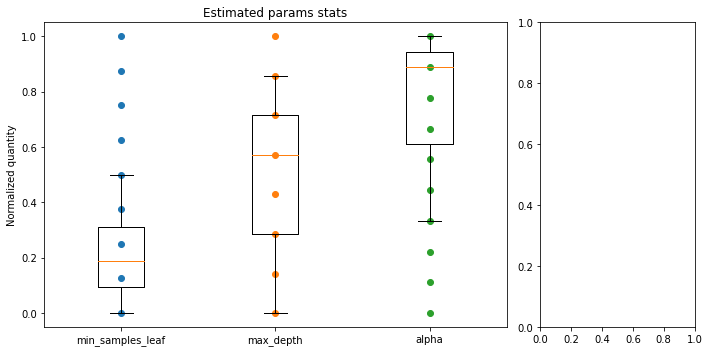

In [62]:
#  plot param distribution 
from geneRNI import tools
import ast

with open(os.path.join(output_dir,'permts.txt'),'r') as f:
    permts = ast.literal_eval(f.read())
with open(os.path.join(output_dir, 'sampled_permts.txt'), 'r') as f:
    sampled_permts = ast.literal_eval(f.read())
tools.GOF.boxplot_params(best_params, priors = permts, samples = sampled_permts)

In [48]:
# plot precision vs racals
precision, recall, average_precision = tools.GOF.calculate_PR(gene_names=gene_names, scores=scores, tests=tests, details = True)

utils.PR_curve_average(recall=recall, precision=precision, average_precision=average_precision)
utils.PR_curve_gene(gene_names=gene_names[0:2], precision=precision, recall=recall, average_precision=average_precision)

NameError: name 'scores' is not defined

In [ ]:
# write test data for R
TS_data, time_points, SS_data, gene_names = f_data_dream(size, network)
np.savetxt('data/test_data.csv',SS_data.transpose(), delimiter=',')

In [ ]:
# calculate precision score for r results
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import sys
dir_main = 'C:/Users/nourisa/Downloads/testProjs/omics'

sys.path.insert(0, dir_main)
from geneRNI import tools

size = 10 # [10,100]
network = 1 # [1-5]

def f_golden_dream(size, network): 
    """ retreives golden links for dreams for given size and network """
    dir_ = os.path.join(dir_main,f'dynGENIE3/dynGENIE3_data/dream4/gold_standards/{size}/DREAM4_GoldStandard_InSilico_Size{size}_{network}.tsv')
    return pd.read_csv(dir_, names=['Regulator','Target','Weight'] ,sep='\t') 
def f_dir_links(size, network):
    """ returns the dir to the stored links """
    return os.path.join(dir_main,f'results/test_links.csv')
def f_data_dream(size, network): 
    """ retreives train data for dreams for given size and network"""
    (TS_data, time_points, SS_data) = pd.read_pickle(os.path.join(dir_main,f'dynGENIE3/dynGENIE3_data/dream4/data/size{size}_{network}_data.pkl'))
    gene_names = [f'G{i}' for i in range(1,size+1)]
    return TS_data, time_points, SS_data, gene_names
TS_data, time_points, SS_data, gene_names = f_data_dream(size, network)
links = pd.read_csv(f_dir_links(size, network) )
goldens = f_golden_dream(size, network)
# sort links based on each gene
links_sorted = tools.sort_links(links,gene_names)
goldens_sorted = tools.sort_links(goldens,gene_names)
# calculate PR
scores = np.array(list(goldens_sorted.values()))
tests = np.array(list(links_sorted.values()))
_, _, _, average_precision_overall = tools.calculate_PR(gene_names=gene_names, scores=scores, tests=tests, details = False)
print('average precision : ',average_precision_overall)

In [154]:
## dynGENIE3
import importlib
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import sys
dir_main = 'C:/Users/nourisa/Downloads/testProjs/omics'

sys.path.insert(0, os.path.join(dir_main,'..'))
from dynGENIE3 import dynGENIE3 
importlib.reload(dynGENIE3)
import _pickle
links_file_name = os.path.join(dir_main,'results/links_dynGENIE3.txt')
TS_data, time_points, SS_data, gene_names = tools.Benchmark.f_data_dream(size=10,network=1)
VIM, alphas, prediction_score, stability_score, treeEstimators,scores_train = dynGENIE3.dynGENIE3(TS_data = TS_data, SS_data = SS_data,time_points=time_points, compute_quality_scores=True)
dynGENIE3.get_link_list(VIM, gene_names=gene_names, file_name=links_file_name)

Tree method: RF
K: sqrt
Number of trees: 1000
alpha min: 0.003434072665420958
alpha max: 0.025135982338199504


running single threaded jobs
Gene 1/10...
Gene 2/10...
Gene 3/10...
Gene 4/10...
Gene 5/10...
Gene 6/10...
Gene 7/10...
Gene 8/10...
Gene 9/10...
Gene 10/10...
Elapsed time: 11.84 seconds


In [163]:
# post process dynGENIE3
import pandas as pd
# oob score
print(f'oob score: mean {np.mean(prediction_score)} std {np.std(prediction_score)}')
links_df = pd.read_csv(links_file_name, delim_whitespace=True, header=None)
links_df.columns = ['Regulator','Target','Weight']
links_df = tools.Links.sort(links_df, gene_names)
golden_links = tools.Benchmark.f_golden_dream(10,1)
_,_,_, average_PR = tools.GOF.calculate_PR(links=links_df, golden_links=golden_links, gene_names=gene_names)
print(-np.log10(.27))

oob score: mean 0.7653465206279951 std 0.20966361225633456
0.5686362358410126
